In [5]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt

# TF-IDF Weight calculation for symptom representation

---
- Input : symptom_disease_dict_{RUN_TAG}.json - Contains HADM_ID to Symptom text and Diagnosis mapping as json object
- Input : icd9_dict_{RUN_TAG}.json - Contains ICD9 Codes of TOP N Diagnoses
- Output : weight_i_j_norm{tag}.csv - TF-IDF weights for symptom representation

In [31]:
cwd = os.getcwd()
print(f"Current working directory : {cwd}")
# Let's define some constants that will be used below in our processing
MAX_NUMBER_OF_DISEASE = 50
RUN_TAG = "_v2.0"
data_dir = cwd + "/../../data/"
SYMPTOM_DISEASE_DICT_FILE_PATH = data_dir + f"symptom_disease_dict_{RUN_TAG}.json"
ICD9_FILE_PATH = data_dir + f"icd9_dict_{RUN_TAG}.json"
SYMPTOM_DICT_FILE_PATH = data_dir + f"symptoms_dict_{RUN_TAG}.json"
TF_IDF_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_{RUN_TAG}.csv"
TF_IDF_NORM_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_norm_{RUN_TAG}.csv"

Current working directory : /Users/vijaymi/Studies/CS-598-DL4Health/Project/135-Disease-Inference-Method/disease_pred_using_bilstm/source


**Load dictionary with symptoms and diagnoses created by data preparation step.**

In [12]:
icd9_dict = None
with open(ICD9_FILE_PATH, 'r') as f:
            icd9_dict = json.load(f)
        
symptom_disease_dict = None
with open(SYMPTOM_DISEASE_DICT_FILE_PATH, 'r') as f:
            symptom_disease_dict = json.load(f)

symptoms_dict = None
with open(SYMPTOM_DICT_FILE_PATH, 'r') as f:
    symptoms_dict = json.load(f)

### Create Symptoms <-> Diagnoses Matrix

Note: This computation is little slow and may take few minutes to run.

In [23]:
number_of_diseases = len(icd9_dict)
number_of_symptoms = len(symptoms_dict)
diagnoses_symptom_vector = pd.DataFrame(np.zeros((number_of_symptoms, number_of_diseases)))

for hadm_id in symptom_disease_dict.keys():
    # print(f"processing {index} - {record}")
    symp_list, icd9_list = symptom_disease_dict[hadm_id]
    for symptom_value in symp_list:
        if symptom_value not in symptoms_dict:
            continue
        for diagnosis_value in icd9_list:
            if diagnosis_value not in icd9_dict:
                continue
            
            # set the vector
            diagnoses_symptom_vector.iat[symptoms_dict[symptom_value], icd9_dict[diagnosis_value]] += 1
            
diagnoses_symptom_vector.T.head()

,0,1,2,3,4,5,6,7,8,9,...,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989
0,327.0,6313.0,19660.0,195.0,630.0,6937.0,331.0,14067.0,207.0,157.0,...,1.0,4.0,1.0,5.0,6.0,5.0,3.0,8.0,1.0,8.0
1,96.0,4857.0,12702.0,96.0,2248.0,5556.0,564.0,10862.0,224.0,154.0,...,3.0,0.0,5.0,3.0,1.0,4.0,2.0,4.0,2.0,4.0
2,542.0,5903.0,10112.0,279.0,1986.0,6338.0,750.0,9406.0,327.0,192.0,...,6.0,4.0,3.0,3.0,6.0,5.0,5.0,7.0,3.0,0.0
3,162.0,3336.0,11478.0,168.0,1948.0,4223.0,551.0,9624.0,333.0,142.0,...,1.0,1.0,4.0,2.0,2.0,2.0,1.0,2.0,0.0,4.0
4,269.0,4114.0,11958.0,165.0,1539.0,4760.0,516.0,10171.0,293.0,121.0,...,0.0,1.0,1.0,3.0,1.0,3.0,3.0,7.0,1.0,5.0


In [25]:
diagnoses_symptom_vector.shape
diagnoses_symptom_vector_binary = (diagnoses_symptom_vector > 0).astype(float)
diagnoses_symptom_vector_binary.head()
diagnoses_symptom_count = diagnoses_symptom_vector_binary.sum(axis=1)

print(f"diagnoses_symptom_count : {diagnoses_symptom_count.shape}")
log_N_di = np.log(MAX_NUMBER_OF_DISEASE / diagnoses_symptom_count)

weight_i_j = diagnoses_symptom_vector.T * log_N_di
print(f"diagnoses_symptom_count[2] : {diagnoses_symptom_count[2]}")
print(f"weight_i_j.shape : {weight_i_j.shape}")
print(f"log_N_di[2] : {log_N_di[2]}")
weight_i_j.head(20)

diagnoses_symptom_count : (3990,)
diagnoses_symptom_count[2] : 50.0
weight_i_j.shape : (50, 3990)
log_N_di[2] : 0.0


,0,1,2,3,4,5,6,7,8,9,...,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.171825,...,0.301105,3.870336,0.328504,2.231436,1.646621,1.505525,1.246546,1.587608,0.415515,6.212230
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.111217,...,0.903315,0.000000,1.642520,1.338861,0.274437,1.204420,0.831031,0.793804,0.831031,3.106115
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.878920,...,1.806631,3.870336,0.985512,1.338861,1.646621,1.505525,2.077577,1.389157,1.246546,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.868784,...,0.301105,0.967584,1.314016,0.892574,0.548874,0.602210,0.415515,0.396902,0.000000,3.106115
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.444528,...,0.000000,0.967584,0.328504,1.338861,0.274437,0.903315,1.246546,1.389157,0.415515,3.882644
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.474866,...,0.602210,5.805504,0.328504,0.446287,1.921058,0.602210,1.662062,0.793804,0.415515,1.553058
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.969798,...,1.204420,0.000000,2.628033,0.446287,0.823311,1.505525,1.246546,0.793804,0.831031,0.776529
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.343514,...,2.107736,2.902752,1.314016,1.338861,2.469932,2.107736,1.662062,0.992255,1.662062,0.776529
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.131420,...,2.107736,0.000000,0.985512,1.338861,0.548874,0.301105,2.493093,0.793804,2.077577,0.776529
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.484933,...,2.408841,0.000000,1.314016,0.892574,2.469932,1.806631,0.000000,0.793804,1.246546,0.000000


In [33]:
from sklearn import preprocessing
weight_i_j = weight_i_j.fillna(0)
weight_i_j = weight_i_j.replace(np.inf, 0)
weight_i_j = weight_i_j.replace(-np.inf, 0)
weight_i_j.head(20)

x = weight_i_j.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
weight_i_j_norm = pd.DataFrame(x_scaled)
weight_i_j_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.817708,...,0.090909,0.666667,0.125,0.833333,0.666667,0.714286,0.500000,1.000,0.2,1.000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802083,...,0.272727,0.000000,0.625,0.500000,0.111111,0.571429,0.333333,0.500,0.4,0.500
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,0.545455,0.666667,0.375,0.500000,0.666667,0.714286,0.833333,0.875,0.6,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.739583,...,0.090909,0.166667,0.500,0.333333,0.222222,0.285714,0.166667,0.250,0.0,0.500
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630208,...,0.000000,0.166667,0.125,0.500000,0.111111,0.428571,0.500000,0.875,0.2,0.625


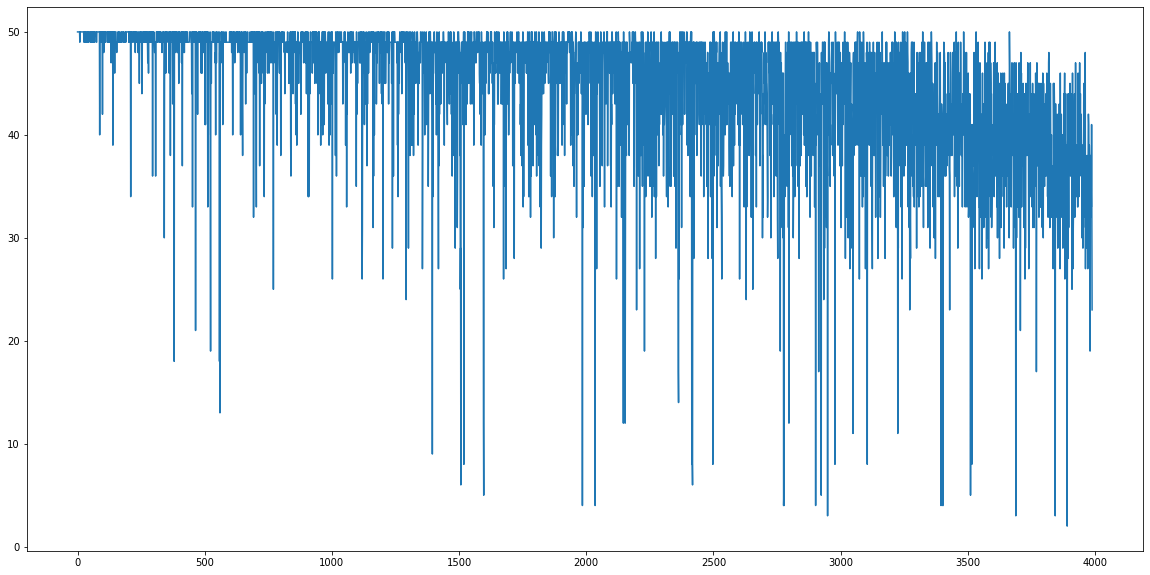

In [34]:
plt.figure(figsize=(20,10))
plt.plot(diagnoses_symptom_count.index, diagnoses_symptom_count)

<h4> Plot of Top 50 disease by associated symptom count </h4>

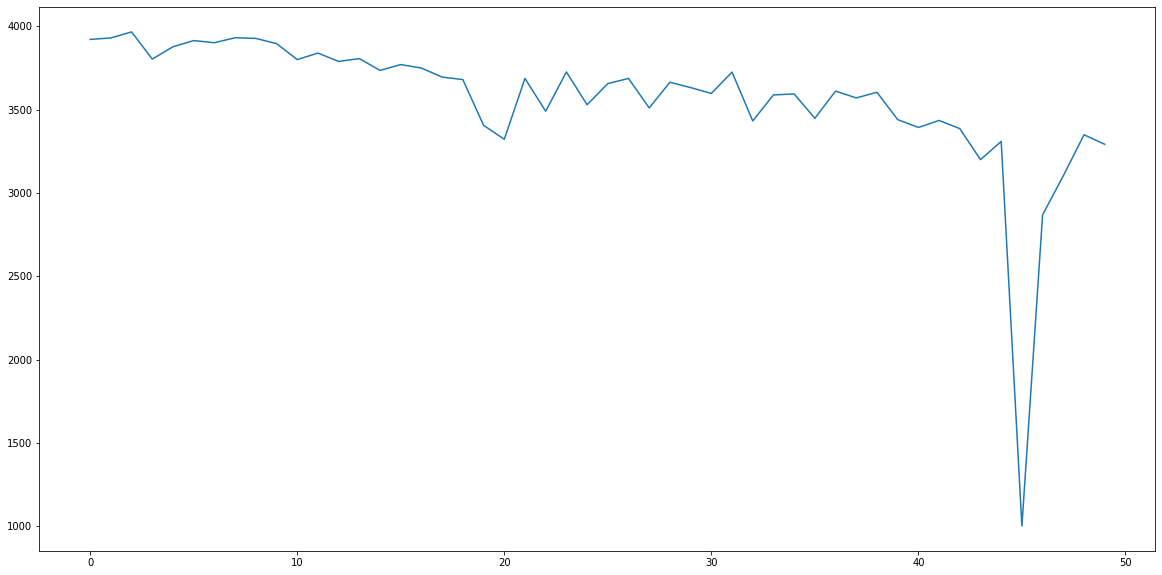

In [28]:
diag_by_symptom_count = diagnoses_symptom_vector_binary.sum(axis=0)
plt.figure(figsize=(20,10))
plt.plot(diag_by_symptom_count.index, diag_by_symptom_count)

<h4> Analysis of Diagnosis count by Hospital Admissions</h4>

(array([3.247e+03, 6.632e+03, 4.346e+03, 9.657e+03, 7.402e+03, 3.169e+03,
        5.155e+03, 3.822e+03, 1.279e+03, 2.133e+03, 1.409e+03, 4.850e+02,
        6.460e+02, 5.000e+02, 5.500e+01, 2.380e+02, 1.590e+02, 1.280e+02,
        9.600e+01, 6.500e+01, 9.000e+00, 5.400e+01, 4.400e+01, 2.600e+01,
        3.100e+01, 1.300e+01, 1.100e+01, 7.000e+00, 1.300e+01, 1.000e+00,
        6.000e+00, 6.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.  ,  2.66,  4.32,  5.98,  7.64,  9.3 , 10.96, 12.62, 14.28,
        15.94, 17.6 , 19.26, 20.92, 22.58, 24.24, 25.9 , 27.56, 29.22,
        30.88, 32.54, 34.2 , 35.86, 37.52, 39.18, 40.84, 42.5 , 44.16,
        45.82, 47.48, 49.14, 50.8 , 52.46, 54.12, 55.78, 57.44, 59.1 ,
        60.76, 62.42, 64.08, 65.74, 67.4 , 69.06, 70.72, 72.38, 74.04,
        75.7 , 77.36,

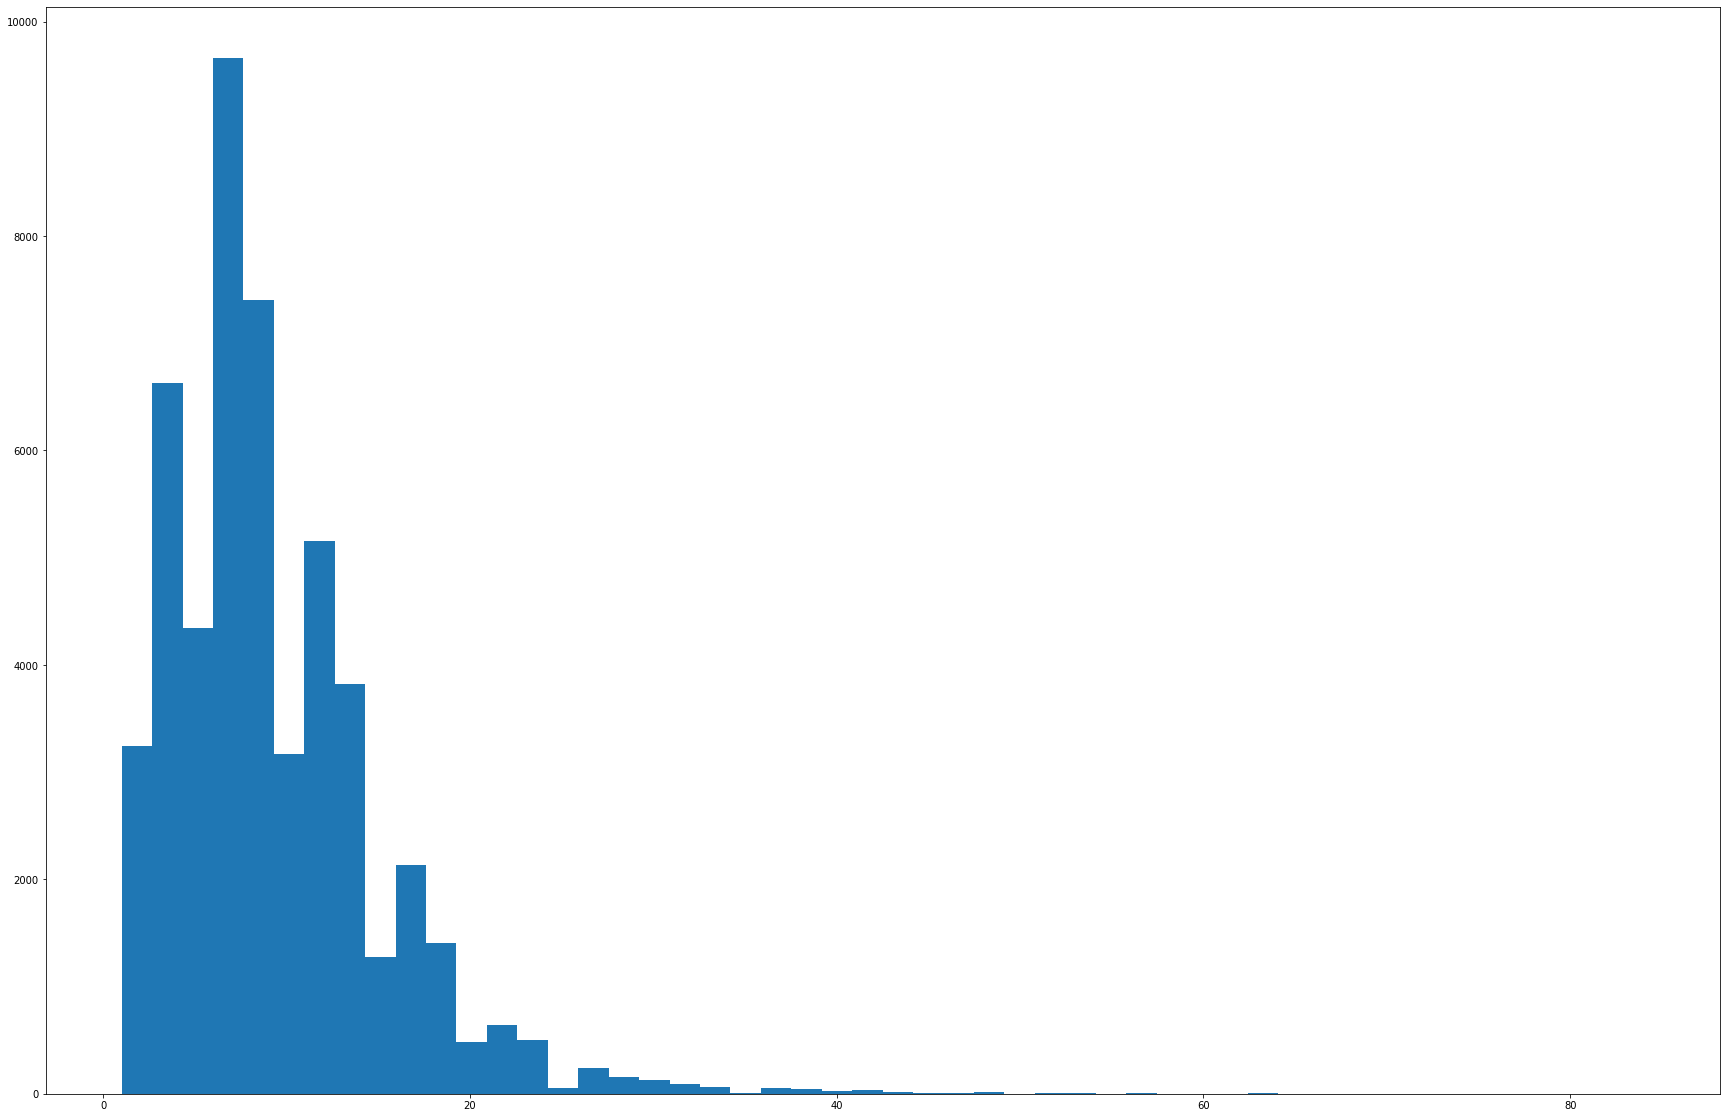

In [110]:
top_N_filtered['ICD9_3CHAR'].value_counts()
top_N_diag_count_by_admission = top_N_filtered.groupby(['HADM_ID'], as_index=False)['ICD9_3CHAR'].count()
plt.figure(figsize=(30,20))
plt.hist(top_N_diag_count_by_admission['ICD9_3CHAR'][:-1], bins=50)

<h3>Saving all the results to files  </h3>

In [32]:
weight_i_j.to_csv(TF_IDF_WEIGHTS_FILE_PATH, index=False)
weight_i_j_norm.to_csv(TF_IDF_NORM_WEIGHTS_FILE_PATH, index=False)